In [1]:
pip install numpy matplotlib osmnx networkx plotly folium scipy python-louvain

Note: you may need to restart the kernel to use updated packages.


In [2]:
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from community import community_louvain
import folium
from folium.plugins import MarkerCluster
from folium.plugins import Fullscreen
from folium.plugins import MiniMap ,MousePosition
import plotly.graph_objects as go
from scipy.stats import entropy

In [29]:
istanbul_lat, istanbul_lon =   40.9925, 29.0420

G = ox.graph_from_point((istanbul_lat, istanbul_lon), dist=3000, dist_type='network', network_type="drive", retain_all=False, truncate_by_edge=False)
# osmnx.graph.graph_from_point(center_point, dist, *, dist_type='bbox' or 'network', network_type={"all", "all_public", "bike", "drive", "drive_service", "walk"}, simplify=True, retain_all=False, truncate_by_edge=False, custom_filter=None)

# Get nodes
istanbul_nodes = list(G.nodes())

# Get edges
istanbul_edges = list(G.edges())

print("Road network for Gazi Street has been created.")
print(f"Total number of nodes: {len(istanbul_nodes)}")
print(f"Total number of edges: {len(istanbul_edges)}")
print(f"Graph type: {type(G)}")

Road network for Gazi Street has been created.
Total number of nodes: 1235
Total number of edges: 2643
Graph type: <class 'networkx.classes.multidigraph.MultiDiGraph'>


In [30]:
# Creating the map
m = folium.Map(location=[istanbul_lat, istanbul_lon], zoom_start=13)

# TileLayer
folium.TileLayer(
    tiles='https://tiles.stadiamaps.com/tiles/alidade_satellite/{z}/{x}/{y}{r}.{ext}',
    attr='Stadia Maps',
    name='Satellite',
    ext='png'
).add_to(m)

# Grouping nodes with MarkerCluster
marker_cluster = MarkerCluster().add_to(m)

# Adding nodes to the map
for node, data in G.nodes(data=True):
    folium.Marker(
        location=[data['y'], data['x']],
        popup=f"Node: {node}",
        icon=folium.Icon(color="blue", icon="flag")
    ).add_to(marker_cluster)

# Extracting road geometries (edges) nx -> geodataframe
edges_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True)

# Adding roads to the map
for _, row in edges_gdf.iterrows():
  
    line = row['geometry']
    
    road_length = row['length']
    
    road_type = row.get('highway', 'Unknown')
    
    if isinstance(road_type, list):
        road_type = ', '.join(road_type)
    
    lat_lon_u = (line.coords[0][1], line.coords[0][0])  # Start point
    lat_lon_v = (line.coords[-1][1], line.coords[-1][0])  # End point
    
    popup_content = f"""
    <strong>Road Information</strong><br>
    <b>Connection Points:</b><br>
    Point ({lat_lon_u}) - Point ({lat_lon_v})<br><br>
    <b>Road Length:</b> {road_length:.2f} m<br>
    <b>Road Type:</b> {road_type.capitalize()}<br>
    """
    
    # Adding road geometry to the map
    folium.PolyLine(
        locations=[(lat, lon) for lon, lat in line.coords],
        color="red", 
        weight=4,     
        opacity=0.7
    ).add_to(m).add_child(folium.Popup(popup_content, max_width=300))

# Adding fullscreen button
folium.plugins.Fullscreen(
    position="topright",
    title="Expand me",
    title_cancel="Click to exit",
    force_separate_button=True,
).add_to(m)

# Adding minimap
folium.plugins.MiniMap(toggle_display=True).add_to(m)

# Showing mouse position
formatter = "function(num) { return num.toFixed(6); }" 
folium.plugins.MousePosition(
    position="topright",
    separator=" | ",
    empty_string="NaN",
    lng_first=True,
    num_digits=6,  # 6-digit precision
    prefix="Coordinates: ",
    lat_formatter=formatter,
    lng_formatter=formatter
).add_to(m)

# Creating right and left layers
layer_right = folium.TileLayer('Stamen Terrain')
layer_left = folium.TileLayer('OpenStreetMap')
sbs = folium.plugins.SideBySideLayers(layer_left=layer_left, layer_right=layer_right)
layer_left.add_to(m)
layer_right.add_to(m)
sbs.add_to(m)

# Finalizing the map
m


In [31]:
degree_centrality = nx.degree_centrality(G)

In [32]:
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

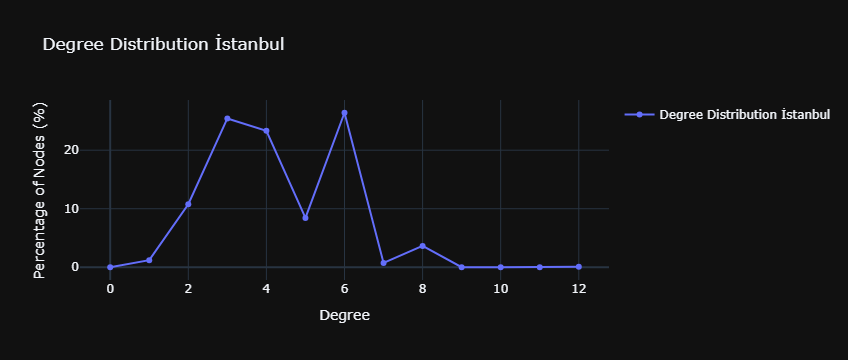

    Degree  Percentage of Nodes
0        0             0.000000
1        1             1.214575
2        2            10.769231
3        3            25.425101
4        4            23.319838
5        5             8.421053
6        6            26.396761
7        7             0.728745
8        8             3.643725
9        9             0.000000
10      10             0.000000
11      11             0.000000
12      12             0.080972


In [33]:
# Calculates the number of nodes for each degree in the network
degree = nx.degree_histogram(G) 

# Calculates the percentage of each degree in the network
perc_degree = [((d * 100) / G.number_of_nodes()) for d in degree] 

# Creates the range of degree values
deg_domain = list(range(0, len(degree)))  

# Creates the Plotly figure
fig = go.Figure()

# Adds data to the figure
fig.add_trace(go.Scatter(
    x=deg_domain, 
    y=perc_degree,
    mode='lines+markers',
    name='Degree Distribution İstanbul',
    line=dict(width=2),  
    marker=dict(size=6)  
))

# Sets layout options
fig.update_layout(
    title="Degree Distribution İstanbul",
    xaxis_title="Degree",
    yaxis_title="Percentage of Nodes (%)",
    showlegend=True,
    template="plotly_dark", 
    hovermode='closest'
)

fig.show()

degree_data = {
    "Degree": deg_domain, 
    "Percentage of Nodes": perc_degree
}

df = pd.DataFrame(degree_data)
print(df)


In [34]:
total_nodes = G.number_of_nodes()

degree_probabilities = [count / total_nodes for count in degree]


entropy = -np.sum(np.array(degree_probabilities) * np.log2(np.array(degree_probabilities) + 1e-9))

print(f"Entropy: {entropy}")

Entropy: 2.457664494267572


In [35]:
closeness_centrality = nx.closeness_centrality(G)

In [36]:
sorted_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

In [37]:
closeness_values = list(closeness_centrality.values())

closeness_stats = {
    'Min': np.min(closeness_values),
    '1st Quartile': np.percentile(closeness_values, 25),
    'Median': np.median(closeness_values),
    '3rd Quartile': np.percentile(closeness_values, 75),
    'Max': np.max(closeness_values),
    'Mean': np.mean(closeness_values),
}

print("Closeness Centrality Statistics:")
for stat, value in closeness_stats.items():
    print(f"{stat}: {value:.4f}")


Closeness Centrality Statistics:
Min: 0.0243
1st Quartile: 0.0325
Median: 0.0369
3rd Quartile: 0.0402
Max: 0.0537
Mean: 0.0365


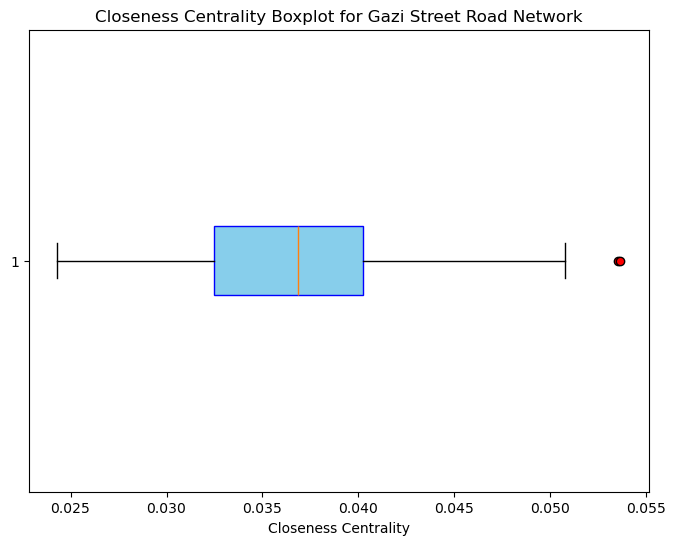

In [38]:
plt.figure(figsize=(8,6))
plt.boxplot(closeness_values, vert=False, patch_artist=True, boxprops=dict(facecolor="skyblue", color="blue"), 
            flierprops=dict(markerfacecolor='red', marker='o', markersize=6, linestyle='none'))
plt.title("Closeness Centrality Boxplot for Gazi Street Road Network")
plt.xlabel("Closeness Centrality")
plt.show()


In [39]:
# Convert the directed graph to an undirected graph
G_undirected = G.to_undirected()

# Detect communities using the Louvain method
partition = community_louvain.best_partition(G_undirected)

# Calculate the modularity value
modularity = community_louvain.modularity(partition, G_undirected)

# Print the results
print(f"Modularity for İstanbul: {modularity}")

Modularity for İstanbul: 0.8922431871612897


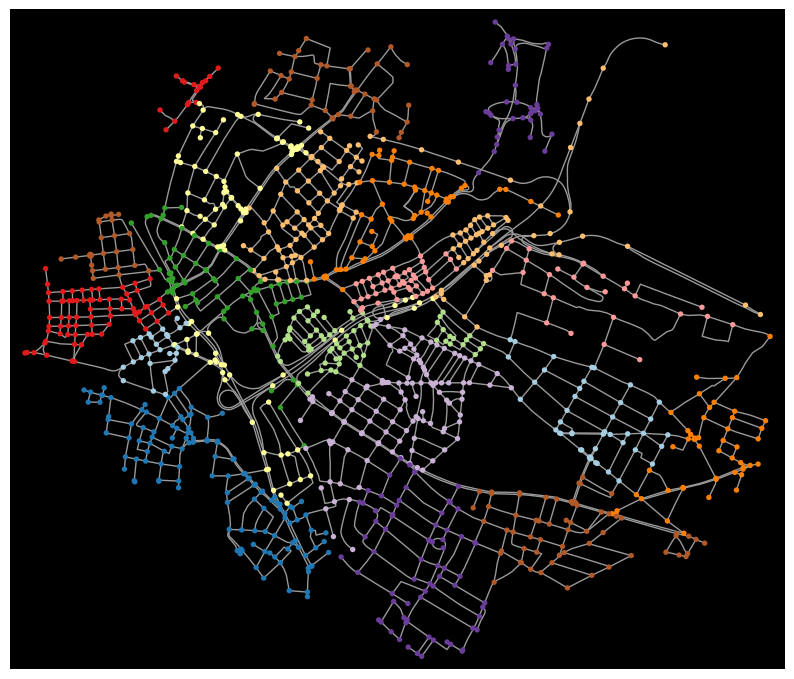

In [40]:
# Assign colors for communities
nx.set_node_attributes(G_undirected, partition, name="attr_city")
nc = ox.plot.get_node_colors_by_attr(G_undirected, attr="attr_city", cmap='Paired')

# Plot the graph
fig, ax = ox.plot_graph(G_undirected, figsize=(10, 10), bgcolor="k", node_color=nc)
plt.pause(0.05)
plt.show()


In [41]:
# Betweenness Centrality Calculation
betweenness_centrality = nx.betweenness_centrality(G)

# Get betweenness centrality values
betweenness_values = list(betweenness_centrality.values())

# Statistical summary
betweenness_stats = {
    'Min': np.min(betweenness_values),
    '1st Quartile': np.percentile(betweenness_values, 25),
    'Median': np.median(betweenness_values),
    '3rd Quartile': np.percentile(betweenness_values, 75),
    'Max': np.max(betweenness_values),
    'Mean': np.mean(betweenness_values),
}

# Print summary statistics
print("Betweenness Centrality Statistics:")
for stat, value in betweenness_stats.items():
    print(f"{stat}: {value:.4f}")


Betweenness Centrality Statistics:
Min: 0.0000
1st Quartile: 0.0024
Median: 0.0081
3rd Quartile: 0.0237
Max: 0.1690
Mean: 0.0173


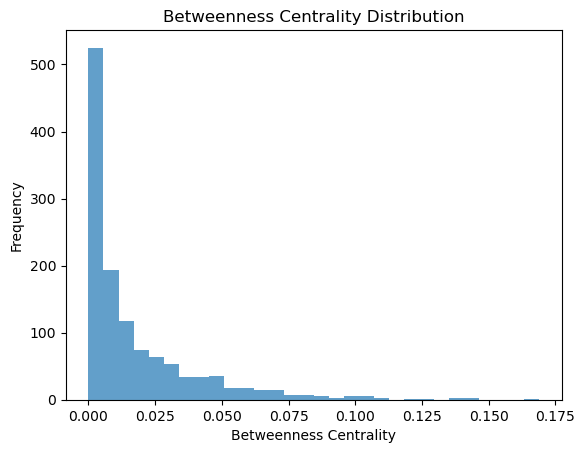

In [42]:
# Plotting the distribution of betweenness centrality values
plt.hist(betweenness_values, bins=30, alpha=0.7)
plt.title('Betweenness Centrality Distribution')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.show()

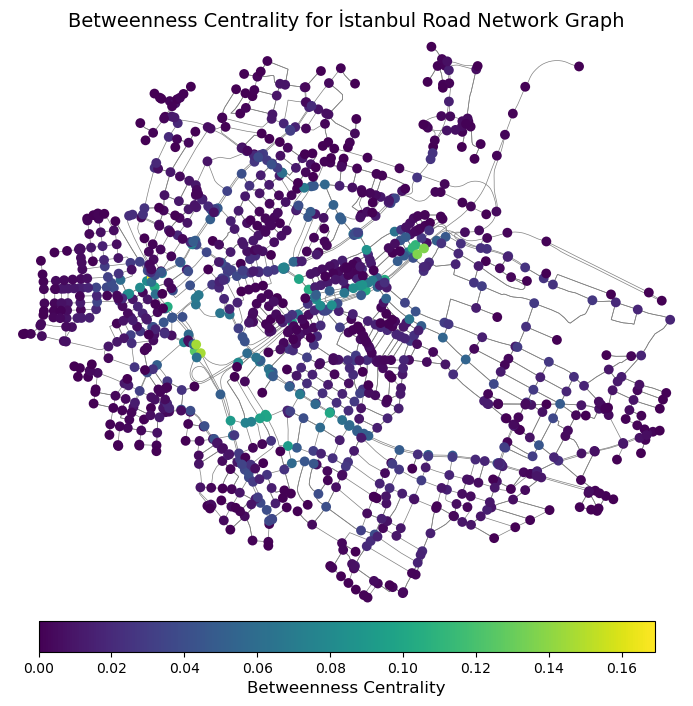

In [43]:
# Determine node colors based on betweenness centrality values
node_colors = [betweenness_centrality[node] for node in G.nodes()]

# Set figure size
fig, ax = plt.subplots(figsize=(10, 8))  # Manually create ax

# Normalize values and choose a color palette (cmap)
norm = mpl.colors.Normalize(vmin=min(betweenness_values), vmax=max(betweenness_values))
cmap = mpl.cm.viridis  # A color palette with green tones is selected

# Plot the network graph
ox.plot_graph(G, node_color=node_colors, node_size=50, edge_color="gray", edge_linewidth=0.5, ax=ax, show=False)

# Add color bar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.05, pad=0.02)
cbar.set_label("Betweenness Centrality", fontsize=12)

# Add title
plt.title("Betweenness Centrality for İstanbul Road Network Graph", fontsize=14)

# Show the plot
plt.show()


In [44]:
pagerank_centrality = nx.pagerank(G, alpha=0.85)

print(len(G))


1235


In [45]:
# Get the top 5 nodes with the highest PageRank values
top_5_pagerank = sorted(pagerank_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print("\nTop 5 Nodes with the Highest PageRank Values:")
for node, pr in top_5_pagerank:
    print(f"Node {node}: PageRank = {pr:.4f}")


Top 5 Nodes with the Highest PageRank Values:
Node 1770321339: PageRank = 0.0034
Node 1573456762: PageRank = 0.0031
Node 1457278008: PageRank = 0.0029
Node 2246399310: PageRank = 0.0027
Node 2433573120: PageRank = 0.0026


In [46]:
node_id = 1770321339

pagerank_value = pagerank_centrality[node_id]

neighbors = list(G.neighbors(node_id))

degree = G.degree(node_id)

print(f"Node {node_id} Information:")
print(f"PageRank Value: {pagerank_value:.4f}")
print(f"Neighbors: {neighbors}")
print(f"Degree: {degree}")


Node 1770321339 Information:
PageRank Value: 0.0034
Neighbors: [467019622, 467019618]
Degree: 5


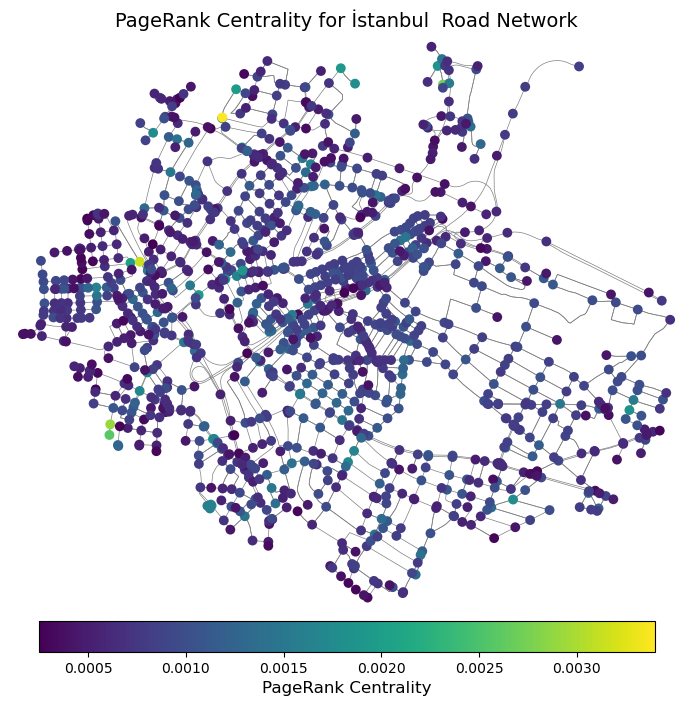

In [48]:
# Set node colors based on PageRank centrality values
node_colors = [pagerank_centrality[node] for node in G.nodes()]

fig, ax = plt.subplots(figsize=(10, 8))

# Normalize values and choose a colormap
norm = mpl.colors.Normalize(vmin=min(pagerank_centrality.values()), vmax=max(pagerank_centrality.values()))
cmap = mpl.cm.viridis

# Plot the network graph
ox.plot_graph(G, node_color=node_colors, node_size=50, edge_color="gray", edge_linewidth=0.5, ax=ax, show=False)

# Add colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.05, pad=0.02)
cbar.set_label("PageRank Centrality", fontsize=12)

# Add title
plt.title("PageRank Centrality for İstanbul  Road Network", fontsize=14)

# Show plot
plt.show()
